In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion, omnipush_datasets

import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind')
# plt.style.use('seaborn-poster')

In [8]:
def eval_experiment(experiment_name, omnipush=False, unimodal=False):
    # Experiment configuration
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_sensors']),
    )

    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )

    if unimodal:
        weight_model = fusion.ConstantWeights(state_dim=1, use_softmax=True, use_log_softmax=True)
    else:
        weight_model = fusion.CrossModalWeights(state_dim=1, use_softmax=True, use_log_softmax=True)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_fusion_model,
        optimizer_names=[
            "e2e_fusion",
            "e2e_image",
            "e2e_force",
            "dynamics_image",
            "dynamics_force",
            "dynamics_recurrent_image",
            "dynamics_recurrent_force",
            "measurement_image",
            "measurement_force",
        ]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    if omnipush:
#         eval_trajectories = omnipush_datasets.load_trajectories(("simpler/val.hdf5", 200), **dataset_args)
        eval_trajectories = omnipush_datasets.load_trajectories(("simpler/train1.hdf5", 200), **dataset_args)

    else:
        dataset_args['start_timestep'] = 100
        eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_1000.hdf5", 100), **dataset_args)
    
    buddy.load_checkpoint()
    pf_fusion_model.image_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
    pf_fusion_model.force_model.dynamics_model.state_noise_stddev = (0.02, 0.02)

    with torch.no_grad():
        panda_training.rollout_and_eval(
            pf_fusion_model,
            eval_trajectories,
            start_time=0,
            max_timesteps=1000,
            particle_count=200,
            noisy_dynamics=True,
            true_initial=True)


[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal] Using device: cuda
[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal] Available checkpoint labels: ['0000000000000274', '0000000000000560', '0000000000000857', '0000000000001152', '0000000000001220', 'phase_4_e2e_joint_unimodal']
[TrajectoriesFile-simpler/train1.hdf5] Loading trajectory from file: <HDF5 file "train1.hdf5" (mode r)>
[TrajectoriesFile-simpler/train1.hdf5] Existing trajectory count: 200
[TrajectoriesFile-simpler/train1.hdf5] Opening file...
[TrajectoriesFile-simpler/train1.hdf5] Closing file...
[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal] Read checkpoint from path: checkpoints/dpf_omnipush_fusion_lr1e-5_uf_unimodal-phase_4_e2e_joint_unimodal.ckpt
[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal] Read checkpoint from path: checkpoints/dpf_omnipush_fusion_lr1e-5_uf_unimodal-phase_4_e2e_joint_unimodal.ckpt
[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal] Instantiating optimizer:  e2e_fusion
[buddy-dpf_omnipush_fusion_lr1e-5_uf_unimodal


0.14482058780337495


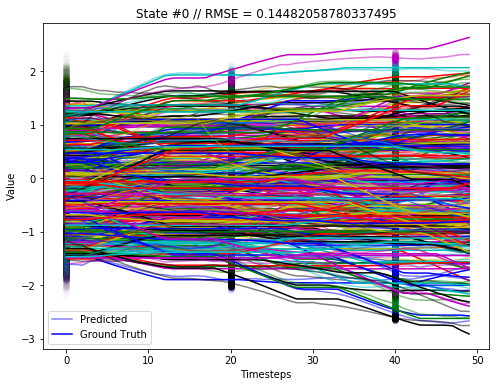

0.15529206496506662


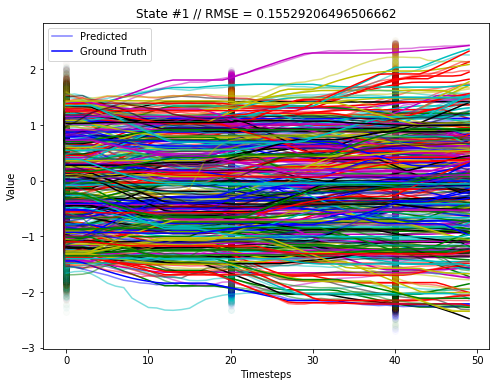

In [9]:
eval_experiment("dpf_omnipush_fusion_lr1e-5_uf_unimodal", omnipush=True, unimodal=True)

[buddy-dpf_fusion_mujoco_blackout0_unimodal] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_unimodal] Available checkpoint labels: ['0000000000001000', '0000000000002000', '0000000000003000', '0000000000004000', '0000000000004690', 'phase_4_e2e_joint_unimodal']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_1000.hdf5] Opening file...
[TrajectoriesFile-...le_push_1000.hdf5] Closing file...
[buddy-dpf_fusion_mujoco_blackout0_unimodal] Legacy checkpoint field: config => optimizer_config
[buddy-dpf_fusion_mujoco_blackout0_unimodal] Legacy checkpoint field: optimizers => optimizer_states
[buddy-dpf_fusion_mujoco_blackout0_unimodal] Legacy checkpoint field: steps
[buddy-dpf_fusion_mujoco_blackout0_unimodal] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_unimodal-phase_4_e2e_joint_unimodal.ckpt
[budd


0.03563552162284082


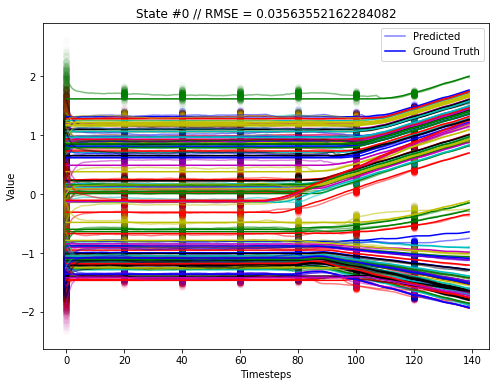

0.021601411320652363


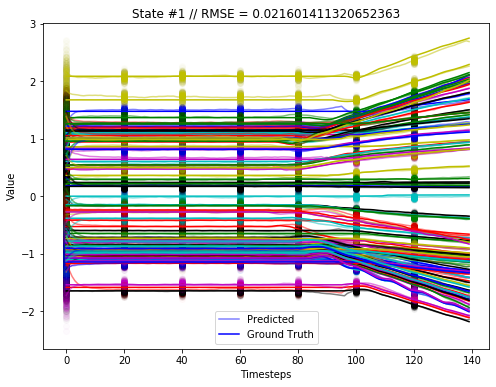

In [29]:
eval_experiment("dpf_fusion_mujoco_blackout0_unimodal", unimodal=True)
# eval_experiment("dpf_omnipush_fusion_lr1e-5_uf", omnipush=True)

[buddy-dpf_fusion_mujoco_blackout4_unimodal] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout4_unimodal] Available checkpoint labels: ['0000000000001000', '0000000000002000', '0000000000003000', '0000000000004000', '0000000000004690', 'phase_4_e2e_joint_unimodal']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_1000.hdf5] Opening file...
[TrajectoriesFile-...le_push_1000.hdf5] Closing file...
[buddy-dpf_fusion_mujoco_blackout4_unimodal] Legacy checkpoint field: config => optimizer_config
[buddy-dpf_fusion_mujoco_blackout4_unimodal] Legacy checkpoint field: optimizers => optimizer_states
[buddy-dpf_fusion_mujoco_blackout4_unimodal] Legacy checkpoint field: steps
[buddy-dpf_fusion_mujoco_blackout4_unimodal] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout4_unimodal-phase_4_e2e_joint_unimodal.ckpt
[budd


0.03812664147032086


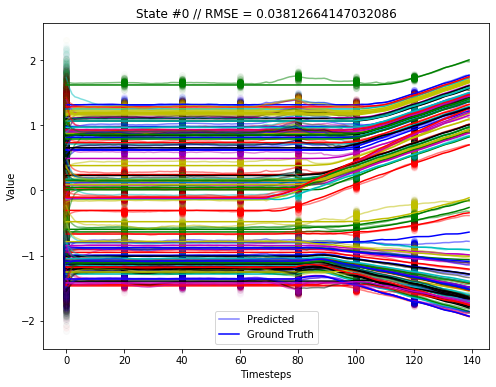

0.03506519907517543


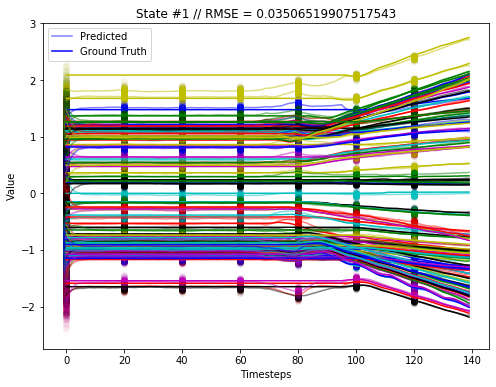

In [30]:
eval_experiment("dpf_fusion_mujoco_blackout4_unimodal", unimodal=True)

[buddy-dpf_fusion_mujoco_blackout8_unimodal] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout8_unimodal] Available checkpoint labels: ['0000000000001000', '0000000000002000', '0000000000003000', '0000000000004000', '0000000000004690', 'phase_4_e2e_joint_unimodal']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_1000.hdf5] Opening file...
[TrajectoriesFile-...le_push_1000.hdf5] Closing file...
[buddy-dpf_fusion_mujoco_blackout8_unimodal] Legacy checkpoint field: config => optimizer_config
[buddy-dpf_fusion_mujoco_blackout8_unimodal] Legacy checkpoint field: optimizers => optimizer_states
[buddy-dpf_fusion_mujoco_blackout8_unimodal] Legacy checkpoint field: steps
[buddy-dpf_fusion_mujoco_blackout8_unimodal] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8_unimodal-phase_4_e2e_joint_unimodal.ckpt
[budd


0.16392197252342477


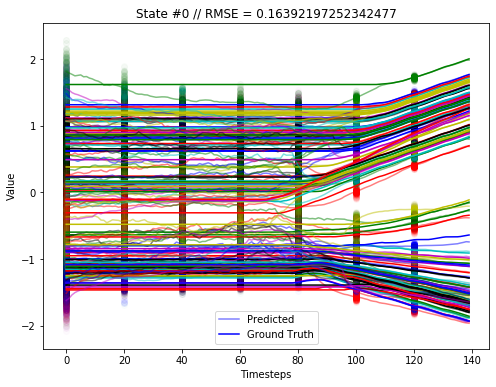

0.14535884366644572


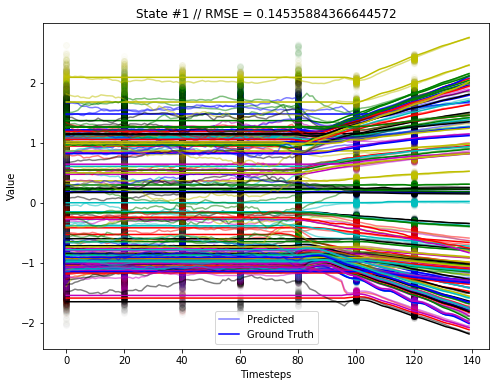

In [31]:
eval_experiment("dpf_fusion_mujoco_blackout8_unimodal", unimodal=True)

[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Using device: cuda
[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Available checkpoint labels: ['0000000000001000', '0000000000002000', '0000000000003000', '0000000000004000', '0000000000004690', 'phase_4_e2e_joint_unimodal']
[TrajectoriesFile-...le_push_1000.hdf5] Loading trajectory from file: <HDF5 file "gentle_push_1000.hdf5" (mode r)>
[TrajectoriesFile-...le_push_1000.hdf5] Existing trajectory count: 1000
[TrajectoriesFile-...le_push_1000.hdf5] Opening file...
[TrajectoriesFile-...le_push_1000.hdf5] Closing file...
[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Legacy checkpoint field: config => optimizer_config
[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Legacy checkpoint field: optimizers => optimizer_states
[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Legacy checkpoint field: steps
[buddy-dpf_fusion_mujoco_seq5_fixed_unimodal] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq5_fixed_unimodal-phase_4_e2e_joint_unimodal.ckp


0.17069017161802907


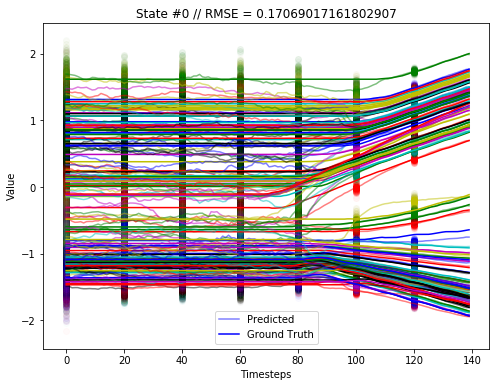

0.14930908326481296


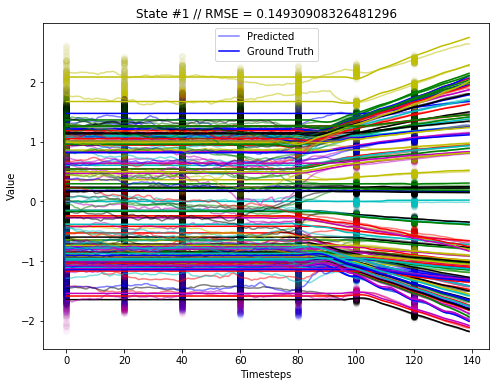

In [32]:
eval_experiment("dpf_fusion_mujoco_seq5_fixed_unimodal", unimodal=True)

In [ ]:
eval_experiment("dpf_fusion_mujoco_blackout8_unimodal", unimodal=True)

In [ ]:
eval_experiment("dpf_fusion_mujoco_blackout8_2x_tuned")

[buddy-dpf_fusion_mujoco_seq5_fixed] Using device: cuda
[buddy-dpf_fusion_mujoco_seq5_fixed] Loaded metadata: {'image_blackout_ratio': 0.0, 'sequential_image_rate': 5, 'start_timestep': 0, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-dpf_fusion_mujoco_seq5_fixed] Available checkpoint labels: ['0000000000023000', '0000000000024000', '0000000000025000', '0000000000026000', '0000000000026725', 'phase_2_measurement_pretrain', 'phase_3_e2e_individual', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_fixed] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq5_fixed-0000000000026725.ckpt
[buddy-dpf_fusion_mujoco_seq5_fixed] Loaded checkpoint at step: 26725
['0000000000023000', '0000000000024000', '0000000000025000', '0000000000026000', '0000000000026725', 'phase_2_measurement_pretrain', 'phase_3_e2e_individual', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_seq5_fixed] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_seq


0.029868327594074436


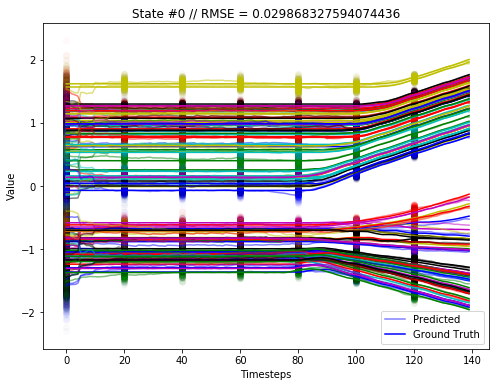

0.026930772149652716


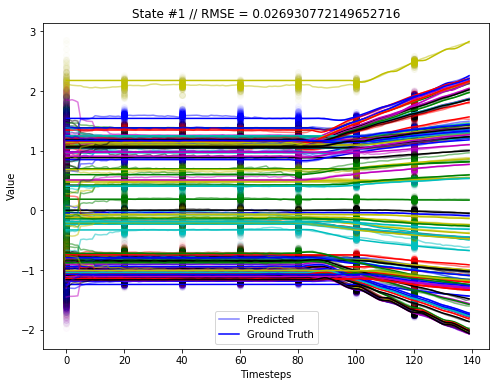

In [11]:
eval_experiment("dpf_fusion_mujoco_seq5_fixed")